## Machine Learning Spam Classifier

In [1]:
from sklearn import svm

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

In [2]:
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [3]:
clf.predict([[2., 2.]])

array([1])

Import some libraries that we might need later on

In [4]:
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

Load the spam classification dataset and look at the first few items

In [5]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We don't need columns 4-6, so we can drop those and tidy things up a bit

In [6]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


Let's see how many of each class we have

In [7]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Remove stopwords and punctuation

In [8]:
nltk.download('stopwords')

def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah dont think goes usf lives around though


We can now try to see a bit more what the dataset looks like by creating wordclouds for each class

In [9]:
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

ham_words = ''
spam_words = ''

# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)


[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


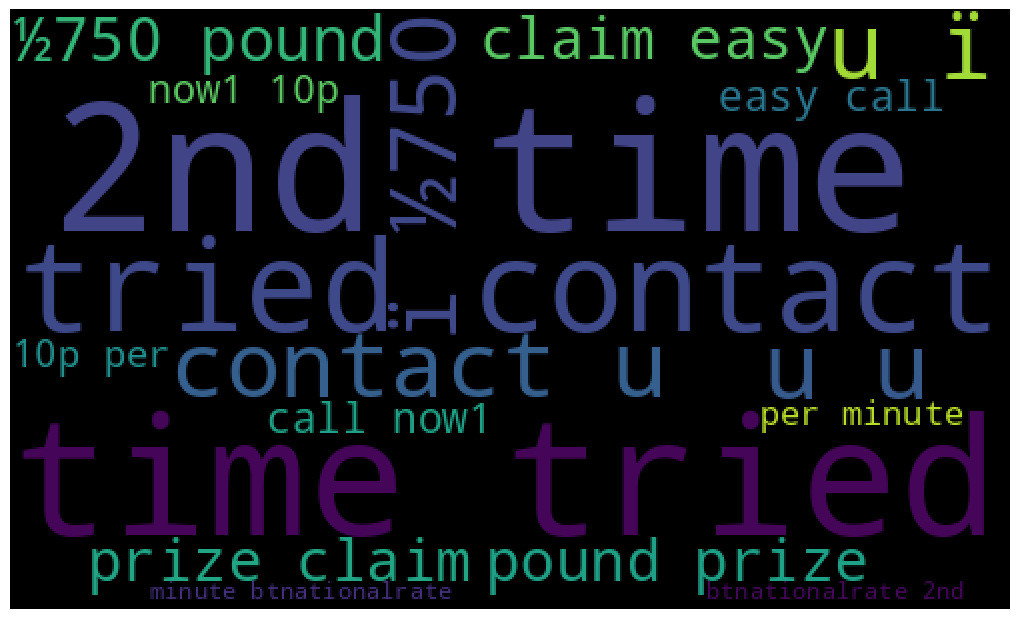

In [10]:
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We can see some words that might be good indicators, so let's try using those as features

In [11]:
feature_words = ["free", "call", "text", "tried", "contact"]

Now, we can convert the spam and ham into 0 and 1 respectively so that the machine can understand.

In [12]:
data = data.replace(['ham','spam'],[0, 1])
data.head(5)

,label,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


In [13]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

In [14]:
def text_to_vector(text):
    word_vector = np.zeros(len(feature_words))
    for word in text.split(" "):
        if word in feature_words:
            word_vector[feature_words.index(word)] += 1
    return np.array(word_vector)

In [15]:
# Convert all texts to vectors
word_vectors = np.zeros((len(text), len(feature_words)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5572, 5)

In [16]:
features = word_vectors

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [18]:
from sklearn.svm import SVC
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [19]:
from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
accuracy_score(y_test , pred)

0.8839712918660287

This seems quite good! But, remember that our classes are not balanced...

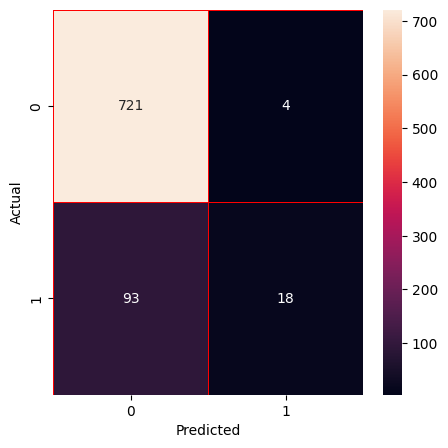

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Maybe we can do better...

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9403)

In [22]:
features = vectors
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)
from sklearn.svm import SVC
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [26]:
from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
accuracy_score(y_test , pred)

0.9748803827751196

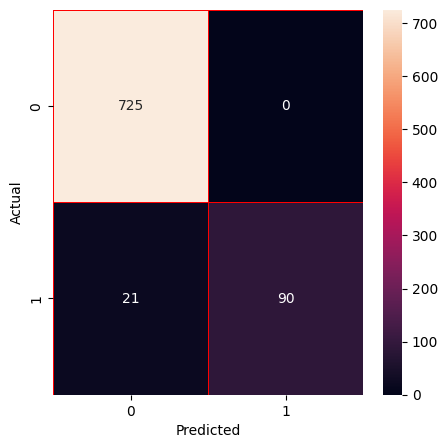

In [27]:
cm = confusion_matrix(y_test, pred)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()